In [151]:
#imports
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend

import keras
import keras.utils
from keras import utils as np_utils

# Conectando com as pastas do Google Drive

In [ ]:
import pandas as pd
import os
os.chdir('drive/My Drive/')

# Criando as métrica de recall, precisão e f1 medida

In [152]:
# criando métrica recall
def recall_m(y_true, y_pred):
    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = backend.sum(backend.round(backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + backend.epsilon())
    return recall

In [153]:
# criando métrica precisão
def precision_m(y_true, y_pred):
    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = backend.sum(backend.round(backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + backend.epsilon())
    return precision

In [154]:
# criando métrica f1
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+backend.epsilon()))

# Carregando o modelo treinado

In [155]:
classifier = keras.models.load_model('/content/drive/My Drive/TCC/modelo3649aws.h5', custom_objects={'f1_m': f1_m, 'recall_m': recall_m, 'precision_m': precision_m})

In [156]:
import numpy as np
from keras.preprocessing import image

In [157]:
from IPython.display import Image

# Teste errado

## Verificando o resultado da predição

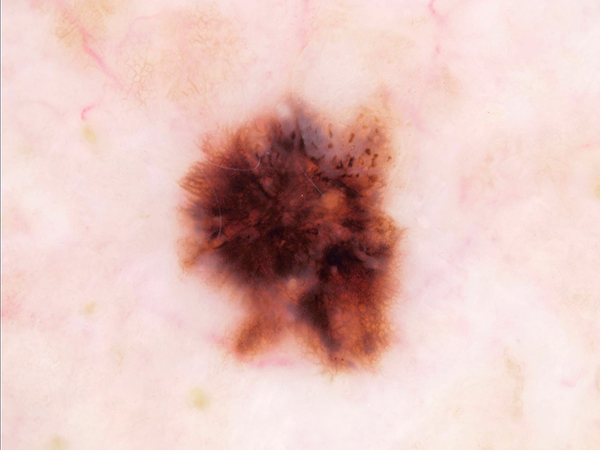

In [158]:
test_image = image.load_img('/content/drive/My Drive/TCC/dataset_treino/maligno/ISIC_0026802.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)

if result[0][0] == 0:
    prediction = 'benigno'
else:
    prediction = 'maligno'

Image(filename='/content/drive/My Drive/TCC/dataset_treino/maligno/ISIC_0026802.jpg')

## Verificando o número de pixels da imagem em específico

In [159]:
test_image

array([[[[245., 214., 209.],
         [240., 212., 208.],
         [241., 216., 211.],
         ...,
         [248., 232., 235.],
         [249., 231., 229.],
         [246., 232., 229.]],

        [[246., 218., 215.],
         [243., 213., 211.],
         [243., 215., 214.],
         ...,
         [250., 230., 231.],
         [246., 225., 224.],
         [249., 229., 228.]],

        [[251., 222., 218.],
         [244., 220., 218.],
         [246., 222., 218.],
         ...,
         [249., 231., 229.],
         [249., 227., 229.],
         [247., 231., 231.]],

        ...,

        [[243., 214., 210.],
         [239., 209., 209.],
         [241., 217., 213.],
         ...,
         [251., 234., 227.],
         [248., 230., 220.],
         [251., 229., 218.]],

        [[243., 210., 205.],
         [240., 212., 209.],
         [241., 217., 213.],
         ...,
         [249., 232., 222.],
         [247., 227., 216.],
         [246., 228., 214.]],

        [[242., 211., 206.],
       

## Analisando as características da rede

In [160]:
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

## Utilizando a última camada convolucional e adicionando no gradiente

In [161]:
tf.compat.v1.disable_eager_execution()

In [162]:
last_conv = classifier.get_layer('conv2d_4')
grads = keras.backend.gradients(classifier.output,last_conv.output)[0]

## Configurando o gradiente

In [163]:
pooled_grads = keras.backend.mean(grads,axis=(0,1,2))
iterate = keras.backend.function([classifier.input],[pooled_grads,last_conv.output[0]])
pooled_grads_value,conv_layer_output = iterate([test_image])
pooled_grads_value

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [164]:
for i in range(32):
    conv_layer_output[:,:,i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output,axis=-1)

In [165]:
for x in range(heatmap.shape[0]):
    for y in range(heatmap.shape[1]):
        heatmap[x,y] = np.max(heatmap[x,y],0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


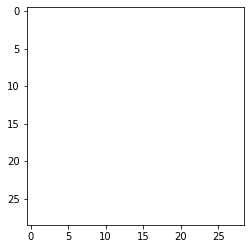

In [166]:
import matplotlib.pyplot as plt
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
plt.imshow(heatmap)

In [167]:
import matplotlib.image as mpimg
image1 = mpimg.imread('/content/drive/My Drive/TCC/dataset_treino/maligno/ISIC_0026802.jpg')
print(image)

<module 'tensorflow.keras.preprocessing.image' from '/usr/local/lib/python3.6/dist-packages/tensorflow/keras/preprocessing/image/__init__.py'>


## Plotando a imagem com o comportamento da rede

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


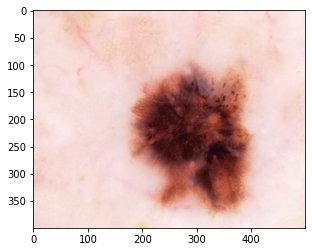

In [170]:
import skimage.transform
upsample = skimage.transform.resize(heatmap, (400,500),preserve_range=True)
plt.imshow(image1)
plt.imshow(upsample,alpha=0.5)
plt.show()

# Teste certo

## Verificando o resultado da predição

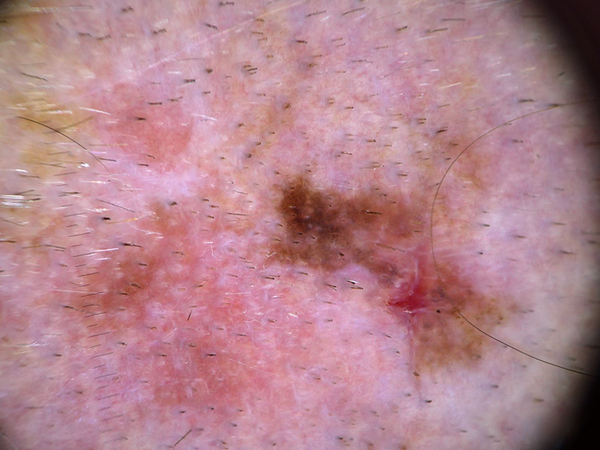

In [ ]:
test_image = image.load_img('/content/drive/My Drive/TCC/dataset_treino/maligno/ISIC_0026754.jpg', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)

if result[0][0] == 0:
    prediction = 'benigno'
else:
    prediction = 'maligno'

Image(filename='/content/drive/My Drive/TCC/dataset_treino/maligno/ISIC_0026754.jpg')

## Verificando o número de pixels da imagem em específico

In [ ]:
test_image

array([[[[ 69.,  53.,  40.],
         [ 93.,  73.,  49.],
         [120., 103.,  83.],
         ...,
         [ 30.,  13.,  19.],
         [ 34.,  15.,  19.],
         [ 36.,  15.,  20.]],

        [[ 87.,  74.,  57.],
         [118.,  94.,  70.],
         [142., 114.,  92.],
         ...,
         [ 29.,  13.,  16.],
         [ 34.,  15.,  17.],
         [ 37.,  16.,  23.]],

        [[ 86.,  61.,  39.],
         [114.,  83.,  55.],
         [132.,  92.,  56.],
         ...,
         [ 28.,  13.,  16.],
         [ 28.,  11.,  17.],
         [ 31.,  15.,  16.]],

        ...,

        [[112.,  83.,  85.],
         [138., 100., 111.],
         [159., 118., 132.],
         ...,
         [ 14.,   9.,   5.],
         [  6.,   0.,   0.],
         [  5.,   1.,   0.]],

        [[110.,  81.,  85.],
         [130., 100., 110.],
         [142., 111., 119.],
         ...,
         [  4.,   2.,   3.],
         [  4.,   0.,   0.],
         [  5.,   1.,   0.]],

        [[ 99.,  73.,  76.],
       

## Analisando as características da rede

In [ ]:
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

## Utilizando a última camada convolucional e adicionando no gradiente

In [ ]:
tf.compat.v1.disable_eager_execution()

In [ ]:
last_conv = classifier.get_layer('conv2d_4')
grads = keras.backend.gradients(classifier.output,last_conv.output)[0]

## Configurando o gradiente

In [ ]:
pooled_grads = keras.backend.mean(grads,axis=(0,1,2))
iterate = keras.backend.function([classifier.input],[pooled_grads,last_conv.output[0]])
pooled_grads_value,conv_layer_output = iterate([test_image])
pooled_grads_value

array([-5.4790567e-19,  3.3221825e-18, -7.0020450e-18,  2.5050861e-18,
       -7.2871732e-19,  2.1926407e-18,  8.3981803e-18, -1.8829624e-19,
        9.6186175e-18,  1.6881404e-19,  1.4164369e-18,  8.4046229e-19,
       -1.6920254e-17,  1.6496503e-17, -8.0611671e-18,  1.2463966e-17,
       -3.4303364e-18,  2.8151589e-18,  6.3556216e-18,  8.6190100e-20,
        1.9534669e-17, -4.5006292e-19,  1.0651660e-17,  2.5331532e-18,
        2.7180212e-18, -2.0351527e-17, -3.0805113e-19,  2.6439333e-18,
       -1.5901666e-17,  2.2731351e-18, -2.0273665e-18,  5.7938480e-18],
      dtype=float32)

In [ ]:
for i in range(32):
    conv_layer_output[:,:,i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output,axis=-1)

In [ ]:
for x in range(heatmap.shape[0]):
    for y in range(heatmap.shape[1]):
        heatmap[x,y] = np.max(heatmap[x,y],0)

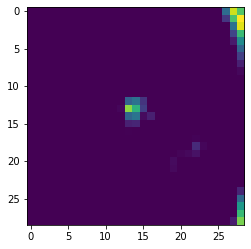

In [ ]:
import matplotlib.pyplot as plt
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)
plt.imshow(heatmap)

In [ ]:
import matplotlib.image as mpimg
image1 = mpimg.imread('/content/drive/My Drive/TCC/dataset_treino/maligno/ISIC_0026754.jpg')
print(image)

<module 'tensorflow.keras.preprocessing.image' from '/usr/local/lib/python3.6/dist-packages/tensorflow/keras/preprocessing/image/__init__.py'>


## Plotando a imagem com o comportamento da rede

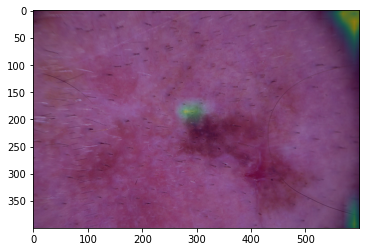

In [ ]:
import skimage.transform
upsample = skimage.transform.resize(heatmap, (400,600),preserve_range=True)
plt.imshow(image1)
plt.imshow(upsample,alpha=0.5)
plt.show()